In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from tabulate import tabulate

In [2]:
#https://stackoverflow.com/questions/46135839/auto-detect-the-delimiter-in-a-csv-file-using-pd-read-csv
import csv

def get_delimiter(file_path, bytes = 4096):
    sniffer = csv.Sniffer()
    data = open(file_path, "r").read(bytes)
    delimiter = sniffer.sniff(data).delimiter
    return delimiter

In [3]:
def read_csv_file(file_path):
    try:
        for encoding in ['latin1', 'ISO-8859-1', 'utf-8']:
            delimiter= get_delimiter(file_path)
            try:
                df = pd.read_csv(file_path, low_memory=False, encoding=encoding, delimiter=delimiter)
                return df, True, None
            except (UnicodeDecodeError, pd.errors.ParserError) as e:
                pass  
        return None, False, f"Impossible de lire {file_path}."
    except FileNotFoundError as e:
        return None, False, e

In [4]:
years = list(range(2005, 2023, 1))
prefixes= ['caracteristiques', 'lieux', 'usagers', 'vehicules']
dataframes= []

for prefix in prefixes:
    datasets = []
    for year in years:
        connector = '_' if year <= 2016 else '-'
        file_name = f'datas/{prefix}{connector}{year}.csv'
        df, success, error = read_csv_file(file_name)
        if success:
            key= {file_name: df}
            datasets.append(key)
        else:
            print(f'{file_name} : {error}')
    dataframes.append(datasets)

print(f'Total datasets: {len(dataframes)}.')

for prefix, df_list in zip(prefixes, dataframes):
    print(f'{prefix}: {len(df_list)}.')

#Correction à la main des deux fichiers pour lesquels il y avait une erreur de frappe dans le nom.


Total datasets: 4.
caracteristiques: 18.
lieux: 18.
usagers: 18.
vehicules: 18.


In [5]:
#affichages
i= 0
group_size = []
for df_list in dataframes:
    total_rows= 0
    for item in df_list:
        for filename, df in item.items():
            total_rows += df.shape[0]
    group_size.append(total_rows)

# Collecter les informations et les afficher sous forme de tableau
i = 0
for df_list in dataframes:
    print('------------')
    total_rows = 0
    group_info = []
    for item in df_list:
        for filename, df in item.items():
            item_rows = df.shape[0]
            item_cols = df.shape[1]
            group_percent = (item_rows * 100) / group_size[i]
            group_duplicate = df.duplicated().sum()
            group_info.append([filename, item_cols, item_rows, round(group_percent), group_duplicate])
            
            column_info = []
            for column in df.columns:
                missing_percent = df[column].isna().sum() / item_rows * 100
                if missing_percent > 0:
                    column_info.append([column, df[column].dtype, round(missing_percent)])
            
            # Affichage des informations sur les colonnes
            print(f'{filename} - {item_cols} variables - {item_rows} lignes / {round(group_percent)}% total')
            if column_info:
                column_headers = ["Colonne", "Type", "Null%"]
                print(tabulate(column_info, headers=column_headers, tablefmt="grid"))
            else:
                print("Aucune colonne avec des valeurs nulles")
    i += 1

    # Affichage des informations sur les fichiers dans le groupe
    group_headers = ["Fichier", "Variables", "Lignes", "% du total", "doublons"]
    print(tabulate(group_info, headers=group_headers, tablefmt="grid"))


------------
datas/caracteristiques_2005.csv - 16 variables - 87026 lignes / 7% total
+-----------+---------+---------+
| Colonne   | Type    |   Null% |
+===========+=========+=========+
| com       | float64 |       0 |
+-----------+---------+---------+
| adr       | object  |      19 |
+-----------+---------+---------+
| gps       | object  |      69 |
+-----------+---------+---------+
| lat       | float64 |      69 |
+-----------+---------+---------+
| long      | float64 |      69 |
+-----------+---------+---------+
datas/caracteristiques_2006.csv - 16 variables - 82993 lignes / 7% total
+-----------+---------+---------+
| Colonne   | Type    |   Null% |
+===========+=========+=========+
| adr       | object  |      13 |
+-----------+---------+---------+
| gps       | object  |      71 |
+-----------+---------+---------+
| lat       | float64 |      71 |
+-----------+---------+---------+
| long      | float64 |      71 |
+-----------+---------+---------+
datas/caracteristiques_20

In [6]:
#recuperer le nom et le type des colonnes
def get_df_structure(df):
    return tuple(sorted((col, df[col].dtype) for col in df.columns))


def group_dataframes_by_struct(dataframes):
    #regrouper les dataframes par groupe de structures similaires
    structure_groups = {}

    for df_list in dataframes:
        for item in df_list:
            for filename, df in item.items():
                structure = get_df_structure(df)
                if structure not in structure_groups:
                    structure_groups[structure] = []
                structure_groups[structure].append(filename)
    
        #regrouper les structures
    grouped_data = []
    for i, (structure, files) in enumerate(structure_groups.items(), start=1):
        unique_dtypes = set(dtype for _, dtype in structure)
        group_info = {
            "group_number": i,
            "num_columns": len(structure),
            "unique_dtypes": len(unique_dtypes),
            "structure": structure,
            "files": files
        }
        grouped_data.append(group_info)
        
    return grouped_data

In [7]:
# Afficher les groupes côte à côte / j'aurais pu le faire directement avec un dataframe
def display_grouped_data(grouped_data):
    table_headers = ["Groupe Numéro", "Nombre de Colonnes", "Nombre de Types Uniques", "Structure (Colonne:Type)", "Fichiers"]
    table_data = []

    for group in grouped_data:
        group_number = group['group_number']
        num_columns = group['num_columns']
        unique_dtypes = group['unique_dtypes']
        structure = group['structure']
        files = group['files']
        
        structure_str = "\n".join([f"{col}:{dtype}" for col, dtype in structure])
        files_str = "\n".join(files)
        
        row = [group_number, num_columns, unique_dtypes, structure_str, files_str]
        table_data.append(row)

    # Afficher le tableau
    print(tabulate(table_data, headers=table_headers, tablefmt="grid"))

In [8]:
#grouper avant traitement pour analyser
display_grouped_data(group_dataframes_by_struct(dataframes))

+-----------------+----------------------+---------------------------+----------------------------+---------------------------------+
|   Groupe Numéro |   Nombre de Colonnes |   Nombre de Types Uniques | Structure (Colonne:Type)   | Fichiers                        |
+=================+======================+===========================+============================+=================================+
|               1 |                   16 |                         3 | Num_Acc:int64              | datas/caracteristiques_2005.csv |
|                 |                      |                           | adr:object                 |                                 |
|                 |                      |                           | agg:int64                  |                                 |
|                 |                      |                           | an:int64                   |                                 |
|                 |                      |                    

In [9]:
#appliquer une structure à un dataframe
def apply_structure_to_df(df, structure):
    
    struct_cols = []
    for col, _ in structure:
        struct_cols.append(col)

    for col in df.columns:
        if col not in struct_cols:
            df.drop(col, axis= 1, inplace= True)
    
    for col, dtype in structure:
        if col not in df.columns:
            df[col] = pd.Series(dtype=dtype) 
        else:
            if pd.api.types.is_integer_dtype(dtype):
                df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0).astype(dtype)
            elif pd.api.types.is_float_dtype(dtype):
                df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0.0).astype(dtype)
            else:
                df[col] = df[col].astype(dtype) 
    
    df = df.reindex(columns= struct_cols)
    return df

In [10]:
#Choisir arbitrairement les structures à garder (les plus récentes)
#j'avais fais un système de séléction automatique mais c'est une très mauvaise idée...
target_df_caract= read_csv_file('datas/caracteristiques-2022.csv')[0]
target_df_caract.rename(columns= {'Accident_Id':'Num_Acc'}, inplace= True)

target_df_lieux= read_csv_file('datas/lieux-2022.csv')[0]
target_df_usagers= read_csv_file('datas/usagers-2022.csv')[0]
target_df_vehicules= read_csv_file('datas/vehicules-2022.csv')[0]

target_df_list = [get_df_structure(target_df_caract), get_df_structure(target_df_lieux), get_df_structure(target_df_usagers), get_df_structure(target_df_vehicules)]

#remplacer
filename, df = next(iter(dataframes[0][-1].items()))
df.rename(columns= {'Accident_Id':'Num_Acc'}, inplace= True)

#brutalement 
i= 0
for df_list in dataframes:
    for item in df_list:
        for filename, df in item.items():
            df = apply_structure_to_df(df, target_df_list[i])
    i+= 1



In [11]:
#grouper après traitement pour résultat
display_grouped_data(group_dataframes_by_struct(dataframes))

+-----------------+----------------------+---------------------------+----------------------------+---------------------------------+
|   Groupe Numéro |   Nombre de Colonnes |   Nombre de Types Uniques | Structure (Colonne:Type)   | Fichiers                        |
+=================+======================+===========================+============================+=================================+
|               1 |                   15 |                         2 | Num_Acc:int64              | datas/caracteristiques_2005.csv |
|                 |                      |                           | adr:object                 | datas/caracteristiques_2006.csv |
|                 |                      |                           | agg:int64                  | datas/caracteristiques_2007.csv |
|                 |                      |                           | an:int64                   | datas/caracteristiques_2008.csv |
|                 |                      |                    

In [13]:
#on va tenter une concaténation sur tous les fichiers
full_datasets = []

for i in range(0, 4, 1):
    full_datasets.append(pd.DataFrame()) 

i= 0
for df_list in dataframes:
    for item in df_list:
        for filename, df in item.items():
            full_datasets[i] = pd.concat([df, full_datasets[i]])
    i+= 1

In [14]:
#temporaire
for df in full_datasets:
    print(f'{df.duplicated().sum()} doublons.')
    print(f'{df.isna().sum()}')
    print(f'{df.dtypes}')
    print(f'{df.shape[0]} lignes.')
    display(df.head())

0 doublons.
Num_Acc         0
jour            0
mois            0
an              0
hrmn            0
lum             0
dep             0
com             2
agg             0
int             0
atm             0
col             0
adr        144509
lat        487068
long       487072
dtype: int64
Num_Acc     int64
jour        int64
mois        int64
an          int64
hrmn       object
lum         int64
dep        object
com        object
agg         int64
int         int64
atm         int64
col         int64
adr        object
lat        object
long       object
dtype: object
1176873 lignes.


,Num_Acc,jour,mois,an,hrmn,lum,dep,com,agg,int,atm,col,adr,lat,long
0,202200000001,19,10,2022,16:15,1,26,26198,2,3,1,3,TEIL(vieille route du),"44,5594200000","4,7257200000"
1,202200000002,20,10,2022,08:34,1,25,25204,2,3,1,3,Miranda,"46,9258100000","6,3462000000"
2,202200000003,20,10,2022,17:15,1,22,22360,2,6,1,2,ROND POINT DE BREZILLET,"48,4931620000","-2,7604390000"
3,202200000004,20,10,2022,18:00,1,16,16102,2,3,8,6,LOHMEYER (RUE),"45,6926520000","-0,3262900000"
4,202200000005,19,10,2022,11:45,1,13,13103,1,1,1,2,ROUTE DE JEAN MOULIN-RN 538,"43,6755790366","5,0927031775"


0 doublons.
Num_Acc          0
catr             0
voie        111985
v1               0
v2         1120249
circ             0
nbv           2731
vosp             0
prof             0
pr          475484
pr1         477303
plan             0
lartpc      274106
larrout     112841
surf             0
infra            0
situ             0
vma         958469
dtype: int64
Num_Acc      int64
catr         int64
voie        object
v1           int64
v2          object
circ         int64
nbv         object
vosp         int64
prof         int64
pr          object
pr1         object
plan         int64
lartpc      object
larrout     object
surf         int64
infra        int64
situ         int64
vma        float64
dtype: object
1176873 lignes.


,Num_Acc,catr,voie,v1,v2,circ,nbv,vosp,prof,pr,pr1,plan,lartpc,larrout,surf,infra,situ,vma
0,202200000001,4,TEIL(vieille route du),0,NaN,2,2,0,1,(1),(1),1,NaN,-1,1,0,1,50.0
1,202200000002,4,NaN,0,NaN,2,2,0,1,(1),(1),1,NaN,-1,1,0,1,50.0
2,202200000003,3,ROND POINT DE BREZILLET,0,NaN,-1,2,0,1,0,0,1,NaN,-1,1,5,1,50.0
3,202200000004,4,QUATORZE JUILLET (RUE DU),0,NaN,1,1,0,2,(1),(1),1,NaN,4,1,0,1,30.0
4,202200000005,3,ROUTE DE JEAN MOULIN-RN 538,0,NaN,2,2,0,1,8,0,1,NaN,-1,1,0,1,80.0


2989 doublons.
Num_Acc              0
id_usager      2380467
id_vehicule    2142195
num_veh              0
place                0
catu                 0
grav                 0
sexe                 0
an_nais              0
trajet               0
secu1          2142195
secu2          2142195
secu3          2142195
locp                 0
actp             56462
etatp                0
dtype: int64
Num_Acc          int64
id_usager       object
id_vehicule     object
num_veh         object
place            int64
catu             int64
grav             int64
sexe             int64
an_nais        float64
trajet           int64
secu1          float64
secu2          float64
secu3          float64
locp             int64
actp            object
etatp            int64
dtype: object
2636377 lignes.


,Num_Acc,id_usager,id_vehicule,num_veh,place,catu,grav,sexe,an_nais,trajet,secu1,secu2,secu3,locp,actp,etatp
0,202200000001,1Â 099Â 700,813Â 952,A01,1,1,3,1,2008.0,5,2.0,8.0,-1.0,-1,-1,-1
1,202200000001,1Â 099Â 701,813Â 953,B01,1,1,1,1,1948.0,5,1.0,8.0,-1.0,-1,-1,-1
2,202200000002,1Â 099Â 698,813Â 950,B01,1,1,4,1,1988.0,9,1.0,0.0,-1.0,0,0,-1
3,202200000002,1Â 099Â 699,813Â 951,A01,1,1,1,1,1970.0,4,1.0,0.0,-1.0,0,0,-1
4,202200000003,1Â 099Â 696,813Â 948,A01,1,1,1,1,2002.0,0,1.0,0.0,-1.0,-1,-1,-1


0 doublons.
Num_Acc              0
id_vehicule    1635811
num_veh              0
senc                 0
catv                 0
obs                  0
obsm                 0
choc                 0
manv                 0
motor          1635811
occutc               0
dtype: int64
Num_Acc          int64
id_vehicule     object
num_veh         object
senc             int64
catv             int64
obs              int64
obsm             int64
choc             int64
manv             int64
motor          float64
occutc         float64
dtype: object
2009395 lignes.


,Num_Acc,id_vehicule,num_veh,senc,catv,obs,obsm,choc,manv,motor,occutc
0,202200000001,813Â 952,A01,1,2,0,2,1,9,1.0,0.0
1,202200000001,813Â 953,B01,1,7,0,2,2,1,1.0,0.0
2,202200000002,813Â 950,B01,2,7,0,2,8,15,1.0,0.0
3,202200000002,813Â 951,A01,2,10,0,2,1,1,1.0,0.0
4,202200000003,813Â 948,A01,2,7,0,2,1,2,1.0,0.0


In [15]:
#on va frontalement modifier chaque dataset pour qu'il coressponde à nos attentes
df = full_datasets[0]
try:
    df.lat = df.lat.str.replace(',', '.')
    df.long = df.long.str.replace(',', '.')
    #df.hrmn = df.hrmn.str.replace(':', '')
except Exception as e:
    print(f'{e}')

In [ ]:
''' 
try:
    #découpage des heures et minutes
    df['hr'] = df['hrmn'].apply(lambda x: x[:2])
    df['mn'] = df['hrmn'].apply(lambda x: x[-2:])
except Exception as e:
    print(f'{e}')'''

In [16]:
#on modifie an
df.loc[df['an'] < 2000, 'an'] += 2000
df['an'] = df['an'].astype(int)

In [17]:
try:
    cols_to_numeric = ['lat', 'long', 'hr',  'mn']
    cols_to_string = ['Num_Acc'] #est-ce qu'on veut réellement que les id soient des int64 ?
    cols_to_date = [] 
    cols_to_drop = ['hrmn']
    df[cols_to_numeric] = df[cols_to_numeric].apply(pd.to_numeric, errors= 'coerce')
    df[cols_to_string] = df[cols_to_string].astype(str)
    df[cols_to_date] = df[cols_to_date].apply(pd.to_datetime, errors= 'coerce')
    df.drop(columns= cols_to_drop, inplace= True)
except Exception as e:
    print(f'{e}')


"['hr', 'mn'] not in index"


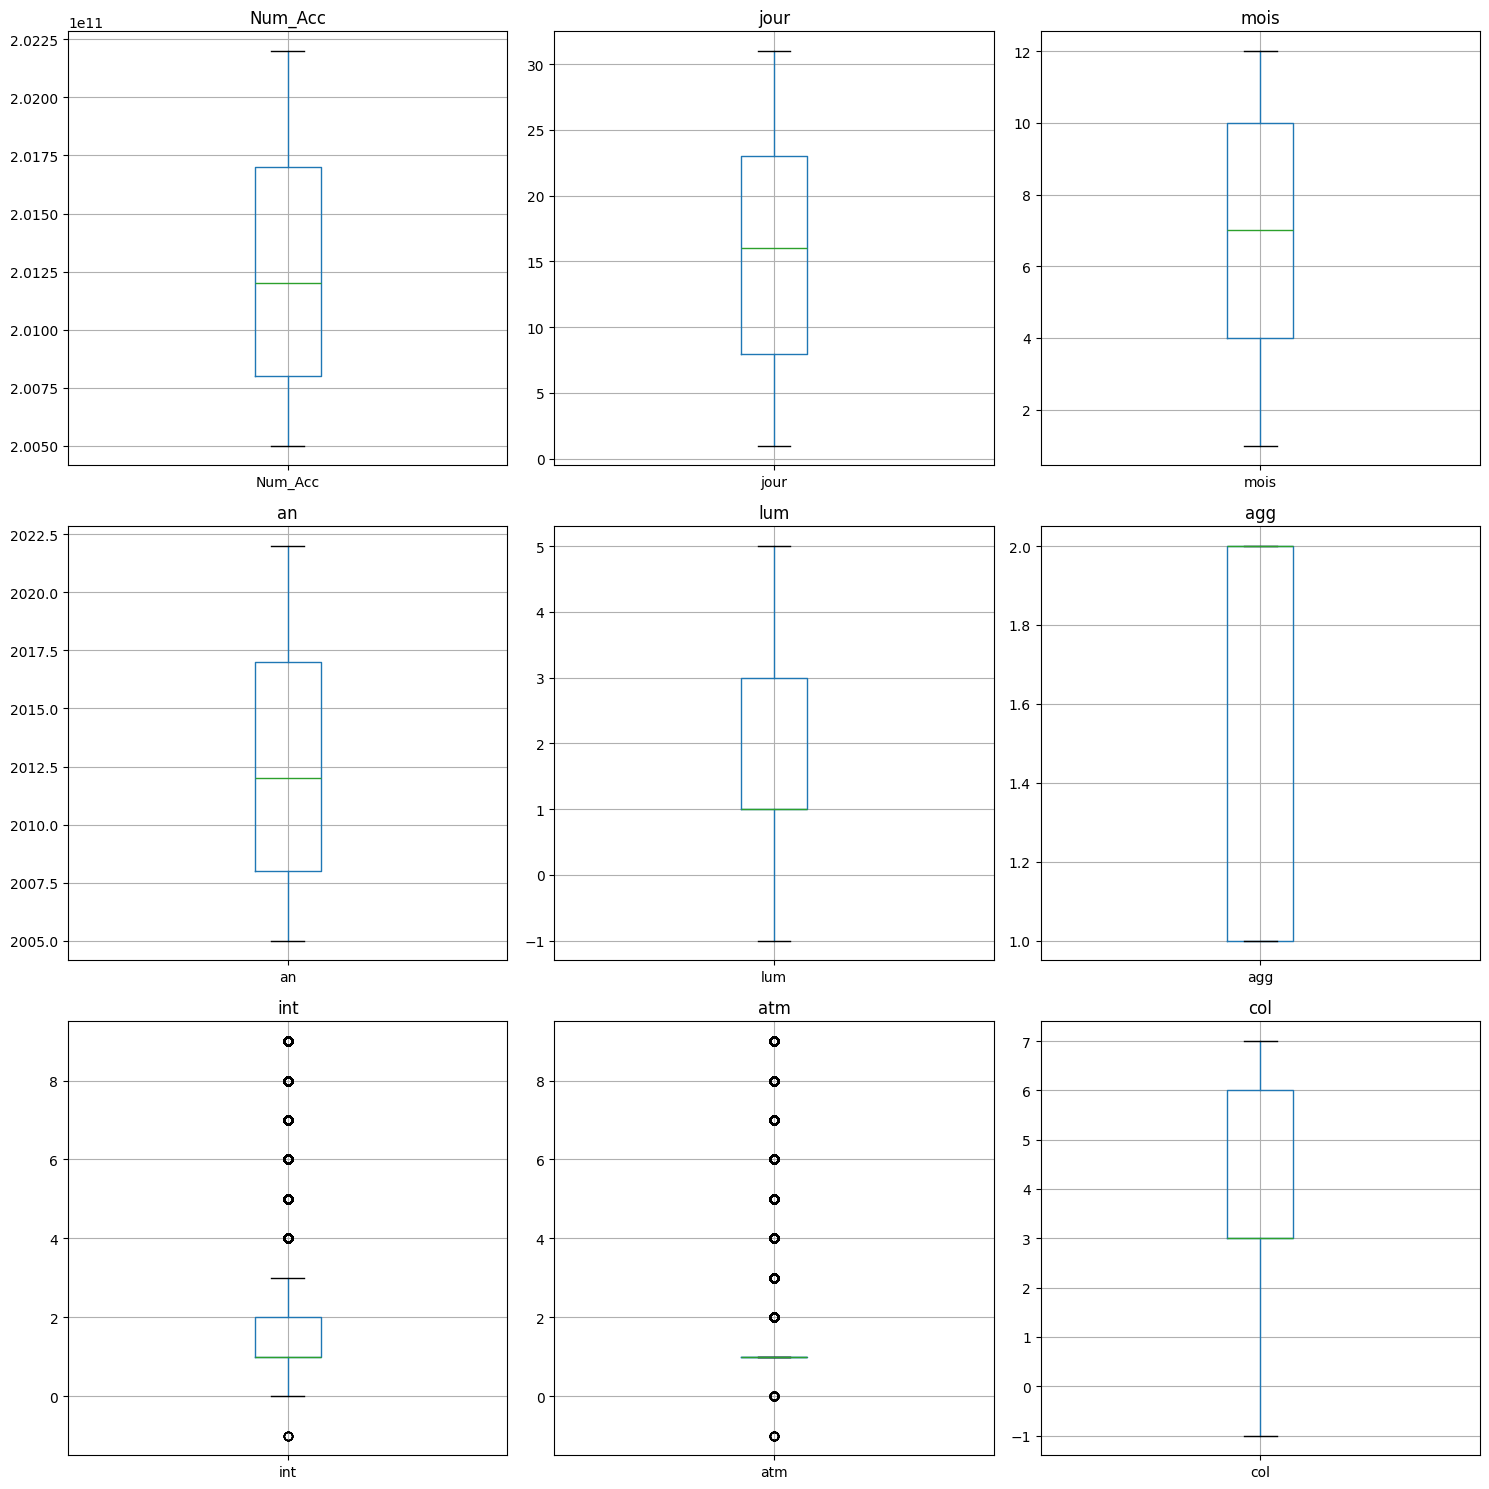

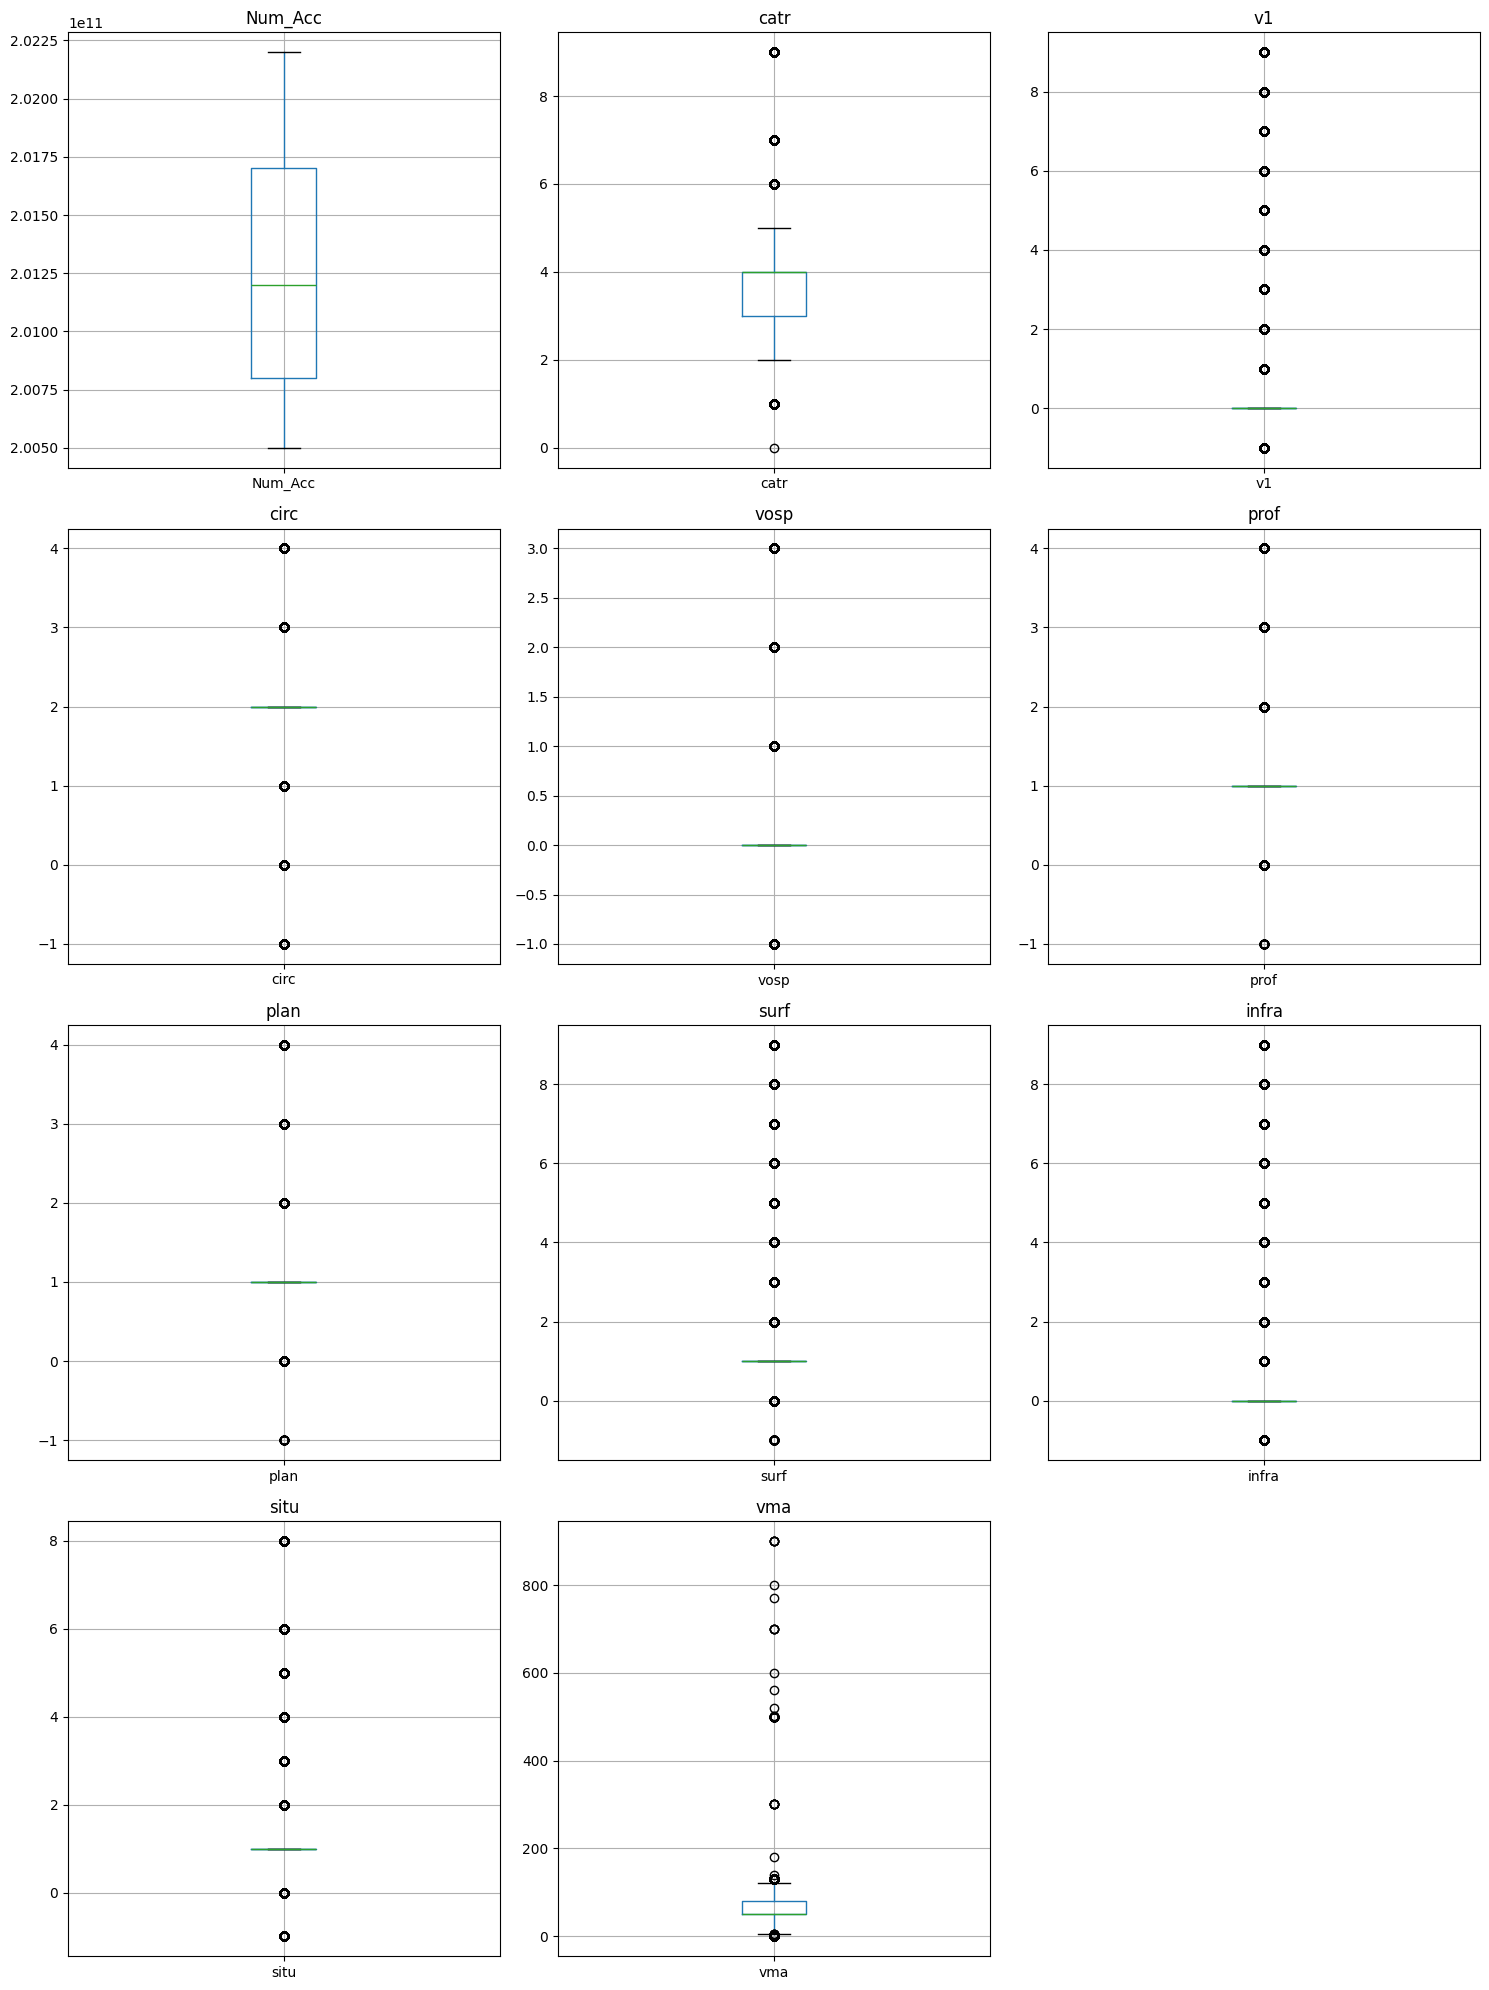

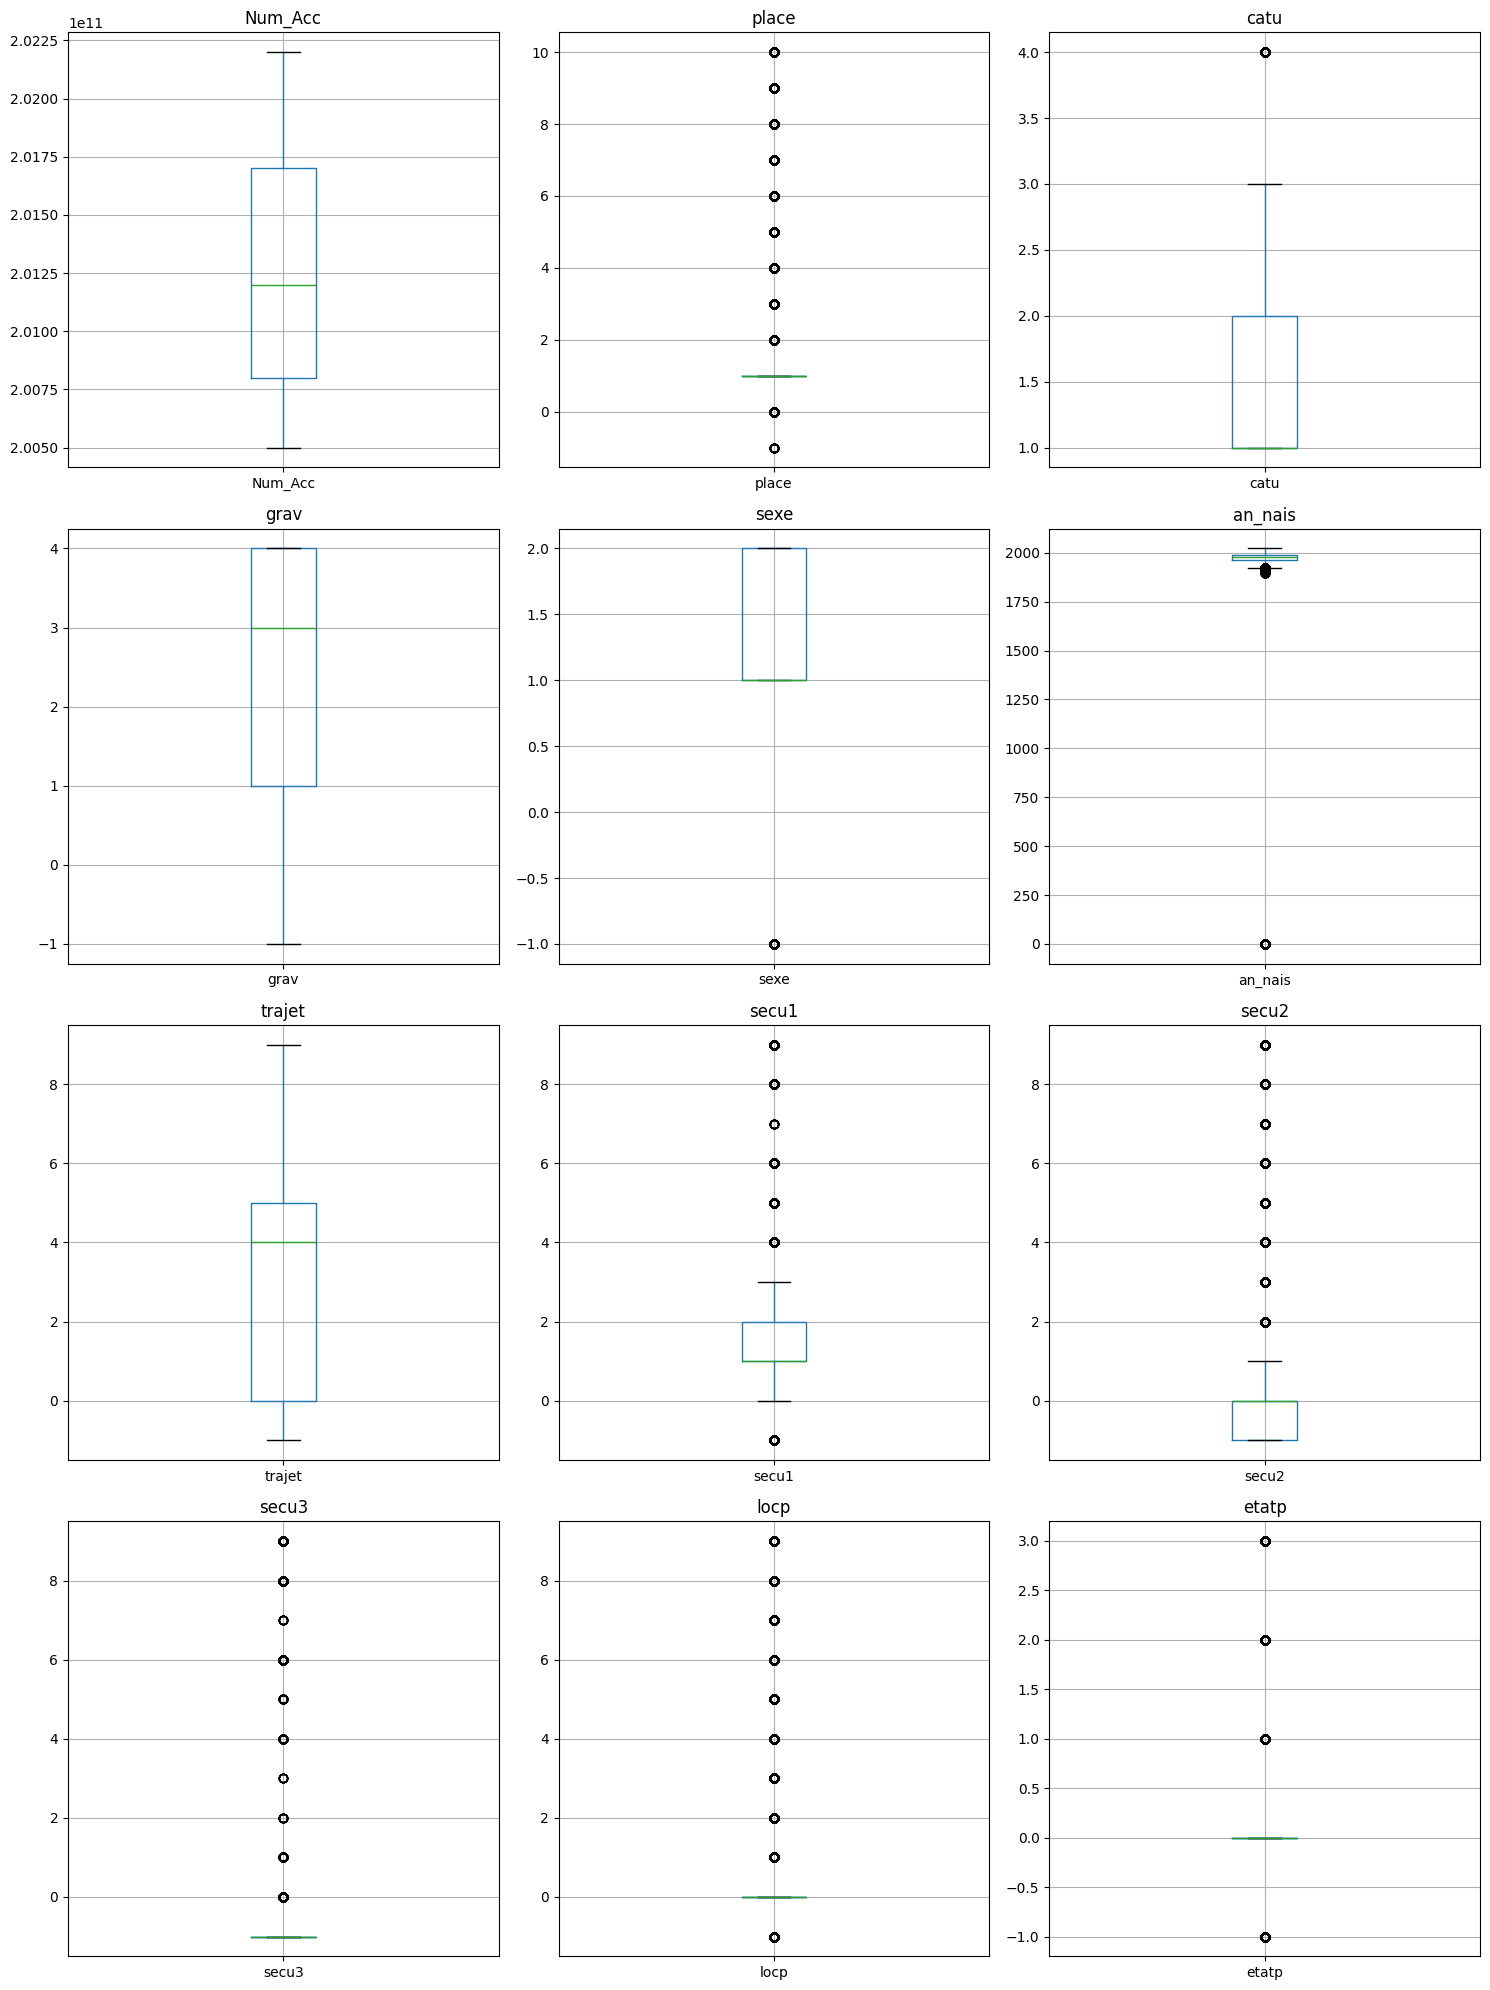

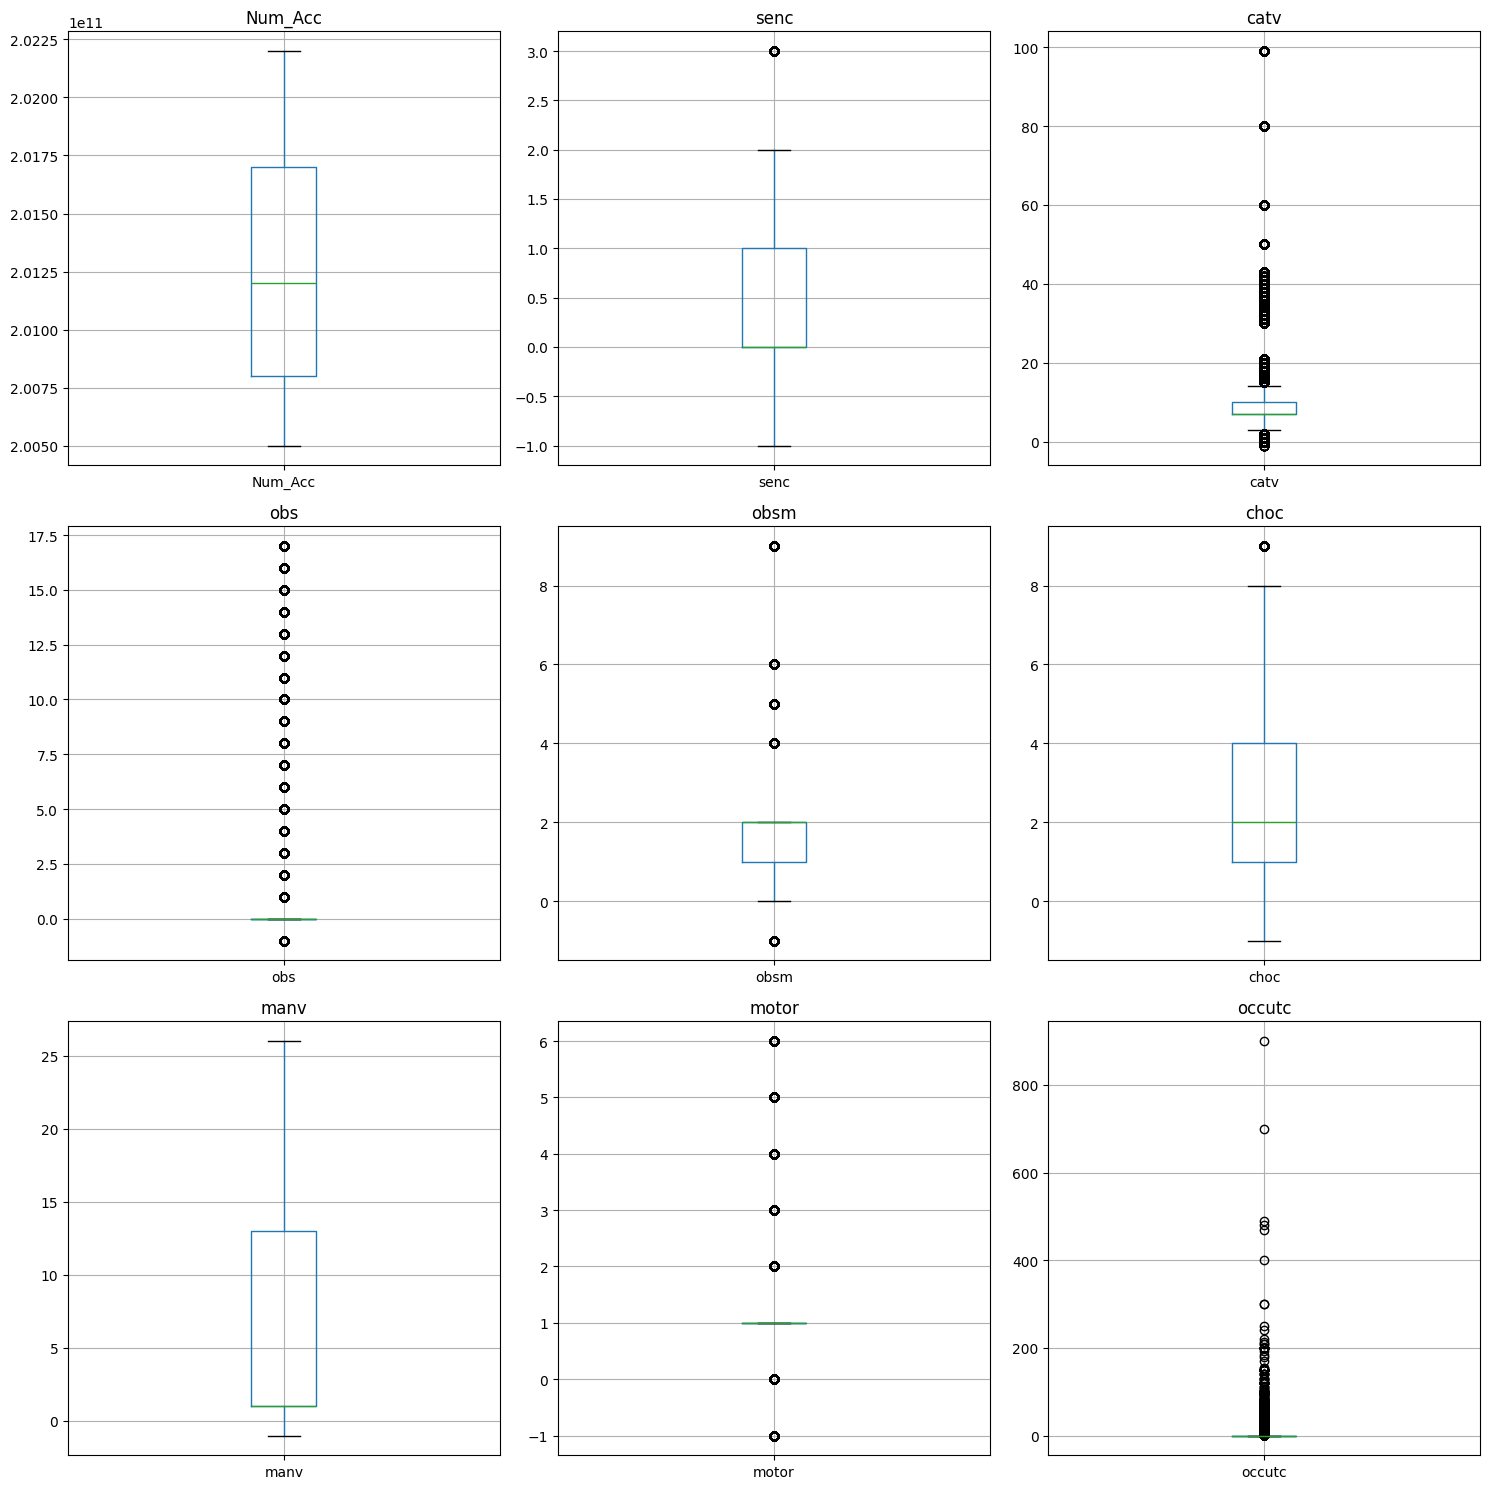

In [18]:
#finalement j'utilise matplotlib car plotly est trop lent ici
for df in full_datasets:
    numeric_cols = df.select_dtypes(include=['number']).columns

    num_cols = 3  
    num_rows = (len(numeric_cols) + num_cols - 1) // num_cols 

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 5))
    axes = axes.flatten()

    for i, col in enumerate(numeric_cols):
        df.boxplot(column=col, ax=axes[i])
        axes[i].set_title(col)

    for i in range(len(numeric_cols), len(axes)):
        fig.delaxes(axes[i])

    plt.tight_layout()
    plt.show()

In [ ]:
for df in full_datasets:
    print('-----')
    for col in df.columns:
        print(f'\n{df[col].value_counts()}')

#pour caract
#['an'] < 2000 = +2000
#['hrmn] enlever ':', découper en deux variables 
#['com'] c'est du float ? ca ne correspond pas à la description de la variable
#['long'] beaucoup de 0.000
#

#pour lieux
#['voie'] ca mélange un peu de tout du numérique et du str
#['nbv'] beaucoup de valeurs très etonnantes [c'est du numérique mais c'est en string]


In [19]:
from ydata_profiling import ProfileReport
for df in full_datasets:
    profile= ProfileReport(df, title= "Report")

ModuleNotFoundError: No module named 'pkg_resources'